In [1]:
from magent2.environments import battle_v4
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Turn on minimap mode for agent's location
env = battle_v4.env(map_size=45, render_mode='rgb_array', minimap_mode=True, max_cycles=300)

In [4]:
# MLP for observation encoding

class MLP(nn.Module):
    def __init__(self, observation_shape=(13, 13, 9), feature_dim=128):
        super(MLP, self).__init__()

        # Calculate the flattened input size
        self.input_dim = observation_shape[0] * observation_shape[1] * observation_shape[2]  # 13 * 13 * 9

        # Define the network layers
        self.layers = nn.Sequential(
            # First flatten the input
            nn.Flatten(),

            # First dense layer with 512 units
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),

            # Second dense layer with feature_dim units (128 in original)
            nn.Linear(512, feature_dim),
            nn.ReLU()
        )

        # Reshape layer to match original output shape (1, feature_dim)
        self.feature_dim = feature_dim

    def forward(self, x):
        # x shape: (13, 13, 9)
        if len(x.shape) == 3:
            x = x.unsqueeze(0)

        # x shape: (batch_size, 13, 13, 9)

        x = x.permute(0, 3, 1, 2)

        # Pass through MLP layers
        features = self.layers(x)

        # Reshape to (batch_size, 1, feature_dim) to match original output shape
        features = features.unsqueeze(1)

        return features

In [5]:
def get_team_observations(env, handle):
    """
    Get team observations from environment and convert to tensor.

    Args:
        env: Environment object
        handle: Team handle (e.g. "red", "blue")

    Returns:
        observations: List of team observations size N x 13 x 13 x 9"""
    observations = []
    for agent in env.possible_agents:
        if handle in agent:
            if env.terminations.get(agent, True) or env.truncations.get(agent, True):
                obs = np.zeros((13, 13, 9))
            else:
                obs = env.observe(agent)
            observations.append(torch.tensor(obs, dtype=torch.float32))

    return observations

In [6]:
def get_agent_positions(team_obs):
    """
    Extract positions of all agents from team observations.

    Args:
        team_obs: List of team observations.
                 Each obs shape is (13, 13, 9) where:
                 - channels[-2:] are the agent's absolute position (x, y)

    Returns:
        Dict of agent positions {agent_idx: (x, y)}
    """
    positions = {}

    # For each agent in the team
    for agent_idx, obs in enumerate(team_obs):
        # Get absolute positions from last two channels
        x_pos = obs[0, 0, -2]  # Second to last channel for x coordinate
        y_pos = obs[0, 0, -1]  # Last channel for y coordinate

        positions[agent_idx] = (x_pos, y_pos)

    return positions

In [7]:
def construct_adjacency_matrix(team_obs, n_neighbors=4):
    """
    Construct adjacency matrix C^t_i for each agent i.

    Args: Dict of team observations {agent_idx: obs}
          n_neighbors: Number of neighbors to consider (default: 4)

    Returns: List of adjacency matrices for each agent
    """
    adjacency_matrices = []

    # Get agent positions
    positions = get_agent_positions(team_obs)
    num_agents = 81

    for i in positions.keys():
        distances = []
        for j in positions.keys():
            if i != j:
                # Calculate Euclidean distance between agent i and j (in normalized coordinates)
                dist = ((positions[j][0] - positions[i][0]) ** 2 + (positions[j][1] - positions[i][1]) ** 2) ** 0.5
                distances.append((dist, j))

        distances.sort(key=lambda x: x[0])  # Sort by distance

        adj_matrix = torch.zeros((n_neighbors + 1, num_agents))

        adj_matrix[0, i] = 1  # Self-connection

        for idx, (dist, neighbor_idx) in enumerate(distances[:n_neighbors]):
            adj_matrix[idx + 1, neighbor_idx] = 1

        while(len(distances) < n_neighbors + 1):
            adj_matrix.append(torch.zeros((n_neighbors + 1, num_agents)))

        adjacency_matrices.append(adj_matrix)

    # Pad with zero matrices if needed
    while len(adjacency_matrices) < num_agents:
        adjacency_matrices.append(torch.zeros((n_neighbors + 1, num_agents)))

    return adjacency_matrices

In [8]:
def process_timestep(env, handle):
    """
    Process one timestep for all agents.

    Args:
        env: Environment object
        handle: Team handle (e.g. "red", "blue")

    Returns:
        observations: List of size N with each element as a tensor of shape (13, 13, 9)
        adjacency_matrices: List of size N with each element as a tensor of shape (5, N)
    """
    # Get team observations
    observations = get_team_observations(env, handle)

    # Get adjacency matrices for all agents
    adjacency_matrices = construct_adjacency_matrix(observations)

    return observations, adjacency_matrices

In [9]:
# Multihead dot-product attention as the convolutional kernel => interaction between agents

class MultiheadAttention(nn.Module):
    """
    Multihead attention module for DGN

    Args:
        n_neighbors: Number of neighbors to consider
        input_dim: Input dimension of the feature vectors
        head_dim: Dimension of each head
        num_heads: Number of attention heads
        output_dim: Output dimension of the feature vectors
    """
    def __init__(self, n_neighbors, input_dim, head_dim, num_heads, output_dim):
        super(MultiheadAttention, self).__init__()

        self.n_neighbors = n_neighbors
        self.input_dim = input_dim
        self.head_dim = head_dim
        self.num_heads = num_heads
        self.output_dim = output_dim

        # Linear transformation for Q, K, V
        self.query_layer = nn.Linear(input_dim, head_dim * num_heads)
        self.key_layer = nn.Linear(input_dim, head_dim * num_heads)
        self.value_layer = nn.Linear(input_dim, head_dim * num_heads)

        # Final transformation
        self.output_layer = nn.Linear(head_dim * num_heads, output_dim)

        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, query, value, key, extra_vector):
        """
        Forward pass for multihead attention

        Args:
            query: Query tensor of shape (batch_size, n_neighbors + 1, L = input_dim)
            value: Value tensor of shape (batch_size, n_neighbors + 1, L = input_dim)
            key: Key tensor of shape (batch_size, n_neighbors + 1, L = input_dim)
            extra_vector: Extra vector of shape (batch_size, 1, n_neighbors + 1)

        Returns:
            Output tensor of shape (batch_size, 1, output_dim)
        """
        if query.dim() == 2:
            query = query.unsqueeze(0)
            key = key.unsqueeze(0)
            value = value.unsqueeze(0)
            extra_vector = extra_vector.unsqueeze(0)

        batch_size = query.size(0)

        # Linear transformation with ReLU
        query_2 = self.relu(self.query_layer(query)) # Shape (batch_size, n_neighbors + 1, head_dim * num_heads)
        key_2 = self.relu(self.key_layer(key))  # Shape (batch_size, n_neighbors + 1, head_dim * num_heads)
        value_2 = self.relu(self.value_layer(value))    # Shape (batch_size, n_neighbors + 1, head_dim * num_heads)

        # Reshape to separate heads
        # Shape (batch_size, n_neighbors + 1, num_heads, head_dim)
        reshaped_query = query_2.view(batch_size, self.n_neighbors + 1, self.num_heads, self.head_dim)
        reshaped_key = key_2.view(batch_size, self.n_neighbors + 1, self.num_heads, self.head_dim)
        reshaped_value = value_2.view(batch_size, self.n_neighbors + 1, self.num_heads, self.head_dim)

        # Permute dimensions for attention
        # Shape (batch_size, num_heads, n_neighbors + 1, head_dim)
        final_query = reshaped_query.permute(0, 2, 1, 3)
        final_key = reshaped_key.permute(0, 2, 1, 3)
        final_value = reshaped_value.permute(0, 2, 1, 3)


        # Scaled dot-product attention
        attention_scores = torch.matmul(final_query, final_key.transpose(-2, -1)) / np.sqrt(self.head_dim)  # (batch_size, num_heads, n_neighbors + 1, n_neighbors + 1)
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, num_heads, n_neighbors + 1, n_neighbors + 1)

        # Apply attention to values
        attention_output = torch.matmul(attention_weights, final_value)  # (batch_size, num_heads, n_neighbors + 1, head_dim)

        # Permute back and reshape
        attention_output = attention_output.permute(0, 2, 1, 3).contiguous()  # (batch_size, n_neighbors + 1, num_heads, head_dim)
        attention_output = attention_output.view(batch_size, self.n_neighbors + 1, -1)  # (batch_size, n_neighbors + 1, num_heads * head_dim)

        # Apply extra vector
        output = torch.matmul(extra_vector, attention_output)  # (batch_size, 1, num_heads * head_dim)

        # Final linear transformation
        output = self.relu(self.output_layer(output))  # (batch_size, 1, output_dim)

        return output

In [10]:
class QNetwork(nn.Module):
    def __init__(self, feature_dim=128, action_dim=21):
        super(QNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(feature_dim * 3, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim)
        )

    def forward(self, feature, relation1, relation2):
        combined = torch.cat([feature, relation1, relation2], dim=-1)
        return self.network(combined)

In [11]:
def find_dead(env, handle):
    """
    Find dead agents in the environment.

    Args:
        env: Environment object
        handle: Team handle (e.g. "red", "blue")

    Returns:
        List of dead agents
    """
    dead_agents = []
    for agent in env.possible_agents:
        if handle in agent:
            if env.terminations.get(agent, True) or env.truncations.get(agent, True):
                agent_id = int(agent.split('_')[1])
                dead_agents.append(agent_id)
    return dead_agents

In [12]:
class DGN(nn.Module):
    def __init__(self, observation_shape=(13, 13, 9), feature_dim=128, action_dim=21):
        super(DGN, self).__init__()

        self.feature_dim = feature_dim

        self.mlp = MLP(observation_shape, feature_dim)

        self.attention1 = MultiheadAttention(n_neighbors=4, input_dim=feature_dim, head_dim=16, num_heads=8, output_dim=feature_dim)
        self.attention2 = MultiheadAttention(n_neighbors=4, input_dim=feature_dim, head_dim=16, num_heads=8, output_dim=feature_dim)

        self.q_network = QNetwork(feature_dim, action_dim)

        # Initialize extra_vector with batch dimension
        self.extra_vector_template = nn.Parameter(torch.zeros(1, 1, 5))
        nn.init.ones_(self.extra_vector_template)
        self.extra_vector_template.data[0, 0, 0] = 1

    def local_features(self, features, adjacency_matrices):
        """
        Compute local features for all agents

        Args:
            features: Tensor of shape (batch_size, N, feature_dim)
            adjacency_matrices: Tensor of shape (batch_size, n_neighbors + 1, N)

        Returns:
            local_features: Tensor of shape (batch_size, n_neighbors + 1, feature_dim)
        """
        local_features = torch.matmul(adjacency_matrices, features)

        return local_features

    def forward(self, team_observations, adjacency_matrices):
        """
        Forward pass for DGN

        Args:
            team_observations: List N Tensor of shape (batch_size, 13, 13, 9)
            adjacency_matrices: List N Tensor of shape (batch_size, n_neighbors + 1, N)

        Returns:
            q_values: Q values of shape (batch_size, action_dim)
        """
        n_agents = 81
        if team_observations[0].dim() == 3:
            team_observations = [obs.unsqueeze(0) for obs in team_observations]
        batch_size = team_observations[0].size(0)
        extra_vector = self.extra_vector_template.expand(batch_size, -1, -1)

        # Etract features for all agents
        team_features = torch.cat([self.mlp(obs) for obs in team_observations], dim=1)  # Shape (batch_size, N, feature_dim)

        # First relation layer
        local_features = [self.local_features(team_features, adjacency_matrix) for adjacency_matrix in adjacency_matrices]  # Shape (batch_size, n_neighbors + 1, feature_dim)
        relation1 = {}
        for i in range(n_agents):
            query = key = value = local_features[i]
            relation1[i] = self.attention1(query, value, key, extra_vector) # Shape (batch_size, 1, feature_dim)

        # Second relation layer
        relation2 = {}
        for i in range(n_agents):
            start_index = max(0, i - 4 // 2)
            end_index = min(n_agents, start_index + 4)

            start_index = max(0, end_index - 4)
            neighbors = list(relation1.values())[start_index:end_index]
            neighbors.append(relation1[i])
            if len(neighbors) < 5:
                for _ in range(5-len(neighbors)):
                    neighbors.append(torch.zeros(relation1[i].shape))
            neighbors = [neighbor.to(device) for neighbor in neighbors]

            query = torch.cat(neighbors, dim=1).to(device)
            key = torch.cat(neighbors, dim=1).to(device)
            value = torch.cat(neighbors, dim=1).to(device)
            # Process attention
            rel2 = self.attention2(query, key, value, extra_vector)
            relation2[i] = rel2 # Shape (batch_size, 1, feature_dim)

        # Compute Q values
        q_values = []
        for i in range(n_agents):
            agent_q = self.q_network(team_features[:, i, :].unsqueeze(1), relation1[i], relation2[i]) # Shape (batch_size, 1, action_dim)
            q_values.append(agent_q)

        # Stack Q values to create Q table
        q_values = torch.cat(q_values, dim=1) # Shape (batch_size, N, action_dim)

        return q_values

In [13]:
num_episodes = 30
learning_rate = 0.001
gamma = 0.95
epsilon = 0.7
epsilon_decay = 0.99
target_update = 10
max_steps = 300
batch_size = 15
handle = 'blue'

In [14]:
# Load pretrained agent
from pretrained_agent import RED_DQN

red_agent = RED_DQN()

In [15]:
def epsilon_greedy_action(agent_idx, q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(21)
    else:
        return q_values[:, agent_idx].argmax().item()

In [16]:
def update_target_model(model, target_model):
    target_model.load_state_dict(model.state_dict())

In [17]:
blue_team = DGN()
blue_team_target = DGN()

blue_team.to(device)
blue_team_target.to(device)

update_target_model(blue_team, blue_team_target)
optimizer = torch.optim.Adam(blue_team.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
blue_team_target.eval()

DGN(
  (mlp): MLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1521, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=128, bias=True)
      (4): ReLU()
    )
  )
  (attention1): MultiheadAttention(
    (query_layer): Linear(in_features=128, out_features=128, bias=True)
    (key_layer): Linear(in_features=128, out_features=128, bias=True)
    (value_layer): Linear(in_features=128, out_features=128, bias=True)
    (output_layer): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
  )
  (attention2): MultiheadAttention(
    (query_layer): Linear(in_features=128, out_features=128, bias=True)
    (key_layer): Linear(in_features=128, out_features=128, bias=True)
    (value_layer): Linear(in_features=128, out_features=128, bias=True)
    (output_layer): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
  )
  (q_network): QNetwork(
    (network): Sequ

In [18]:
from ReplayBuffer import ReplayBuffer

replay_buffer = ReplayBuffer(10000)

In [19]:
for episode in range(num_episodes):
    env.reset()
    # Get initial observations
    team_observations, adj_matrices = process_timestep(env, handle)
    episode_reward = 0

    for step in tqdm(range(max_steps), desc=f"Episode {episode+1}/{num_episodes}"):
        actions = [] # Store actions for blue agent
        rewards = [] # Store rewards for blue agent

        dones = [env.terminations.get(agent_id, True) or env.truncations.get(agent_id, True) for agent_id in [f"{handle}_{i}" for i in range(81)]]

        team_observations = [obs.to(device) for obs in team_observations] # Move observations to GPU
        adj_matrices = [adj_matrix.to(device) for adj_matrix in adj_matrices] # Move adj_matrices to GPU
        q_values = blue_team(team_observations, adj_matrices)

        dead_agents = find_dead(env, handle)

        # Get actions for each agent
        for agent in env.agent_iter():
            end = agent == env.agents[-1]
            observation, reward, terminated, truncated, _ = env.last()
            if terminated or truncated:
                action = None
                if "blue" in agent:
                    actions.append(0)
                    rewards.append(-10)
            elif "red" in agent:
                obs = torch.Tensor(env.observe(agent))
                action = red_agent.get_action(obs)
            elif "blue" in agent:
                # env.agent_selection = blue_0
                agent_idx = int(agent.split('_')[1])
                action = epsilon_greedy_action(agent_idx, q_values, epsilon)
                actions.append(action)
                rewards.append(reward)
            env.step(action)

            if end:
                break

        for dead_agent in dead_agents:
            actions.insert(dead_agent, None)
            rewards.insert(dead_agent, 0)
        # Get next state
        next_observations, next_adj_matrices = process_timestep(env, handle)

        if len(team_observations) != len(next_observations) or len(actions) != len(next_observations) or len(dones) != len(next_observations):
            continue
        else:
            replay_buffer.add(team_observations, actions, rewards, next_observations, torch.Tensor(dones), adj_matrices)

        if replay_buffer.count() > batch_size:
            observations_, actions_, rewards_, next_observations_, dones_, adj_matrices_ = replay_buffer.getBatch(batch_size)

            observations_ = observations_.to(device)
            actions_ = actions_.to(device)
            rewards_ = rewards_.to(device)
            next_observations_ = next_observations_.to(device)
            dones_ = dones_.to(device)
            adj_matrices_ = adj_matrices_.to(device)

            # Compute target Q values
            observations_ = list(observations_.unbind(0))
            adj_matrices_ = list(adj_matrices_.unbind(0))
            next_observations_ = list(next_observations_.unbind(0))

            with torch.no_grad():
                target_values = rewards_.T + gamma * blue_team_target(observations_, adj_matrices_).max(dim=-1).values * (1 - dones_.T)
            q_values_ = blue_team(next_observations_, adj_matrices_) # Shape (batch_size, N, action_dim)

            actions_ = actions_.T # Shape (batch_size, N)

            q_values_ = q_values_[torch.arange(batch_size).unsqueeze(1), torch.arange(81).unsqueeze(0), actions_] # Shape (batch_size, N)
            # Compute loss
            loss = criterion(q_values_, target_values)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Soft update target network
            for target_param, param in zip(blue_team_target.parameters(), blue_team.parameters()):
                target_param.data.copy_(0.99 * target_param.data + 0.01 * param.data)

        # Update state
        observations = next_observations
        adj_matrices = next_adj_matrices
        episode_reward += sum(rewards)
        if all(dones) or all([env.terminations.get(agent_id, True) or env.truncations.get(agent_id, True) for agent_id in [f"red_{i}" for i in range(81)]]):
            break

    epsilon = max(0.1, epsilon * epsilon_decay)

    # Logging

    tqdm.write(f"Episode {episode+1}/{num_episodes}, Total reward: {episode_reward}, Epsilon: {epsilon}")

Episode 1/30: 100%|█████████▉| 299/300 [05:25<00:01,  1.09s/it]


Episode 1/30, Total reward: -969.7950339373201, Epsilon: 0.693


Episode 2/30: 100%|██████████| 300/300 [05:28<00:00,  1.09s/it]


Episode 2/30, Total reward: -929.3900331715122, Epsilon: 0.68607


Episode 3/30: 100%|██████████| 300/300 [05:45<00:00,  1.15s/it]


Episode 3/30, Total reward: -934.0850342651829, Epsilon: 0.6792092999999999


Episode 4/30: 100%|██████████| 300/300 [05:35<00:00,  1.12s/it]


Episode 4/30, Total reward: -787.1900276495144, Epsilon: 0.6724172069999999


Episode 5/30: 100%|█████████▉| 299/300 [05:34<00:01,  1.12s/it]


Episode 5/30, Total reward: -805.2950272476301, Epsilon: 0.6656930349299999


Episode 6/30: 100%|█████████▉| 299/300 [05:38<00:01,  1.13s/it]


Episode 6/30, Total reward: -789.0950262686238, Epsilon: 0.6590361045806998


Episode 7/30: 100%|██████████| 300/300 [05:34<00:00,  1.11s/it]


Episode 7/30, Total reward: -786.3900270452723, Epsilon: 0.6524457435348928


Episode 8/30: 100%|██████████| 300/300 [05:23<00:00,  1.08s/it]


Episode 8/30, Total reward: -813.8850282831118, Epsilon: 0.6459212860995439


Episode 9/30: 100%|██████████| 300/300 [05:11<00:00,  1.04s/it]


Episode 9/30, Total reward: -733.5700266202912, Epsilon: 0.6394620732385484


Episode 10/30: 100%|█████████▉| 299/300 [05:16<00:01,  1.06s/it]


Episode 10/30, Total reward: -832.2950282981619, Epsilon: 0.6330674525061629


Episode 11/30: 100%|██████████| 300/300 [05:13<00:00,  1.04s/it]


Episode 11/30, Total reward: -808.5850283633918, Epsilon: 0.6267367779811013


Episode 12/30: 100%|██████████| 300/300 [05:19<00:00,  1.06s/it]


Episode 12/30, Total reward: -1102.690039953217, Epsilon: 0.6204694102012902


Episode 13/30: 100%|█████████▉| 299/300 [05:30<00:01,  1.11s/it]


Episode 13/30, Total reward: -830.2950280895457, Epsilon: 0.6142647160992774


Episode 14/30: 100%|██████████| 300/300 [05:26<00:00,  1.09s/it]


Episode 14/30, Total reward: -1157.9900421937928, Epsilon: 0.6081220689382846


Episode 15/30: 100%|█████████▉| 299/300 [05:23<00:01,  1.08s/it]


Episode 15/30, Total reward: -1059.0950379082933, Epsilon: 0.6020408482489017


Episode 16/30: 100%|██████████| 300/300 [05:23<00:00,  1.08s/it]


Episode 16/30, Total reward: -1002.1750373998657, Epsilon: 0.5960204397664127


Episode 17/30: 100%|██████████| 300/300 [05:28<00:00,  1.09s/it]


Episode 17/30, Total reward: -688.4750227006152, Epsilon: 0.5900602353687486


Episode 18/30: 100%|█████████▉| 299/300 [05:28<00:01,  1.10s/it]


Episode 18/30, Total reward: -723.4950233353302, Epsilon: 0.5841596330150611


Episode 19/30: 100%|██████████| 300/300 [05:13<00:00,  1.05s/it]


Episode 19/30, Total reward: -875.6800309345126, Epsilon: 0.5783180366849106


Episode 20/30: 100%|█████████▉| 299/300 [05:34<00:01,  1.12s/it]


Episode 20/30, Total reward: -697.0950223887339, Epsilon: 0.5725348563180614


Episode 21/30: 100%|█████████▉| 299/300 [05:44<00:01,  1.15s/it]


Episode 21/30, Total reward: -655.0950205223635, Epsilon: 0.5668095077548808


Episode 22/30: 100%|██████████| 300/300 [05:27<00:00,  1.09s/it]


Episode 22/30, Total reward: -701.8900228329003, Epsilon: 0.561141412677332


Episode 23/30: 100%|██████████| 300/300 [05:45<00:00,  1.15s/it]


Episode 23/30, Total reward: -611.0850207125768, Epsilon: 0.5555299985505586


Episode 24/30: 100%|█████████▉| 299/300 [05:37<00:01,  1.13s/it]


Episode 24/30, Total reward: -679.1950214877725, Epsilon: 0.549974698565053


Episode 25/30: 100%|██████████| 300/300 [05:24<00:00,  1.08s/it]


Episode 25/30, Total reward: -529.3400206984952, Epsilon: 0.5444749515794024


Episode 26/30: 100%|██████████| 300/300 [05:33<00:00,  1.11s/it]


Episode 26/30, Total reward: -741.2950246185064, Epsilon: 0.5390302020636084


Episode 27/30: 100%|██████████| 300/300 [05:46<00:00,  1.15s/it]


Episode 27/30, Total reward: -682.2050223331898, Epsilon: 0.5336399000429723


Episode 28/30: 100%|██████████| 300/300 [05:41<00:00,  1.14s/it]


Episode 28/30, Total reward: -720.4250247180462, Epsilon: 0.5283035010425426


Episode 29/30: 100%|██████████| 300/300 [05:51<00:00,  1.17s/it]


Episode 29/30, Total reward: -727.5850235382095, Epsilon: 0.5230204660321172


Episode 30/30: 100%|██████████| 300/300 [05:28<00:00,  1.10s/it]

Episode 30/30, Total reward: -639.3550214357674, Epsilon: 0.517790261371796


In [20]:
torch.save(blue_team.state_dict(), 'blue_team_model_V3.pth')

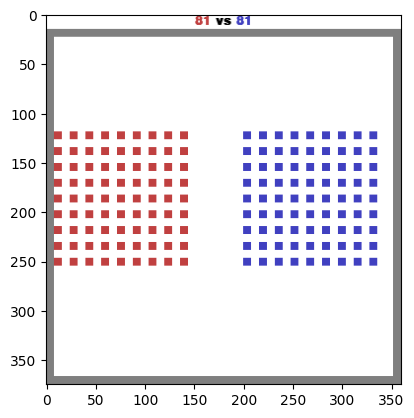

In [22]:
plt.imshow(env.render())